In [1]:
import sys
sys.path.append('/home/koreyr/scripts')
from block import *
from traj_calc import *
from free_energy import *

import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from xvg_file import subplot_snsheat, subplot_imshow

In [3]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

sns.set_style("whitegrid")


In [4]:
outdir = './Analysis/'
pdb = '../../aFUS/protein.ff.gro'
top = '../../aFUS/protein.t.top'
rep0 = '../../hdFUS_2x/prod.xtc'
helixpdb = '../../aFUS/helix.pdb'

print("outdir:", outdir)
print("pdb:", pdb)
print("helix pdb:", helixpdb)
print("trjaectory:", rep0)


outdir: ./Analysis/
pdb: ../../aFUS/protein.ff.gro
helix pdb: ../../aFUS/helix.pdb
trjaectory: ../../hdFUS_2x/prod.xtc


In [5]:
trj = md.load(rep0, top=pdb, stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames


In [6]:
trj.timestep

80.0

In [7]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

#residues = 58
#residue_offset = 390
residue_offset = 0
prot_res_renum = np.asarray(prot_res)+residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:", residue_number)


** SYSTEM INFO **

Number of atoms: 624

Number of residues: 44

Number of protein residues: 42

Number of frames: 3224

Starting frame: 0

Last frame: 3224

sequence:  [NGLY1, MET2, ALA3, SER4, ASN5, ASP6, TYR7, THR8, GLN9, GLN10, ALA11, THR12, GLN13, SER14, TYR15, GLY16, ALA17, TYR18, PRO19, THR20, GLN21, PRO22, GLY23, GLN24, GLY25, TYR26, SER27, GLN28, GLN29, SER30, SER31, GLN32, PRO33, TYR34, GLY35, GLN36, GLN37, SER38, TYR39, SER40, GLY41, TYR42, SER43, CGLN44]

residue names:  ['NGLY', 'MET', 'ALA', 'SER', 'ASN', 'ASP', 'TYR', 'THR', 'GLN', 'GLN', 'ALA', 'THR', 'GLN', 'SER', 'TYR', 'GLY', 'ALA', 'TYR', 'PRO', 'THR', 'GLN', 'PRO', 'GLY', 'GLN', 'GLY', 'TYR', 'SER', 'GLN', 'GLN', 'SER', 'SER', 'GLN', 'PRO', 'TYR', 'GLY', 'GLN', 'GLN', 'SER', 'TYR', 'SER', 'GLY', 'TYR', 'SER', 'CGLN']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

Residue Number R

/home/koreyr/scripts/block.py:31: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


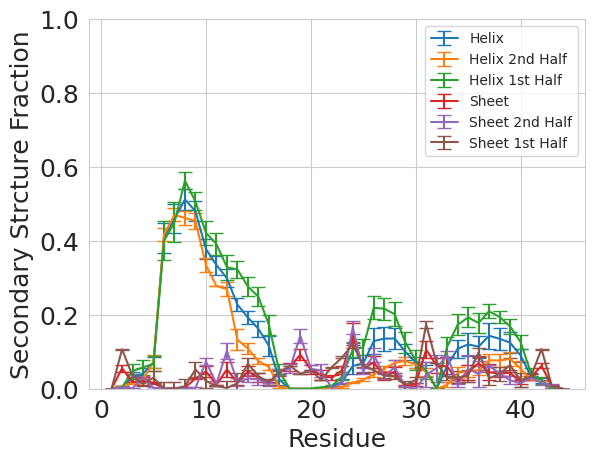

In [52]:
trjH1 = md.load(rep0, top=pdb, stride=1)
H1 = top.select("resid 0 to 43")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames
half = int(np.floor(frames/2))

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 0
hres_renum = np.asarray(h_res)+residue_offset


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)
dsspH1_h2 = md.compute_dssp(trjH1[half:-1], simplified=True)
dsspH1_h1 = md.compute_dssp(trjH1[0:half], simplified=True)

H1_H, H1_E = dssp_convert(dsspH1)
H1_H_h2, H1_E_h2 = dssp_convert(dsspH1_h2)
H1_H_h1, H1_E_h1 = dssp_convert(dsspH1_h1)

plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
plt.errorbar(
    hres_renum, H1_H_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Helix 2nd Half')
plt.errorbar(
    hres_renum, H1_H_h1[:, 0], yerr=H1_H_h1[:, 1], capsize=5, label='Helix 1st Half')
plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')
plt.errorbar(
    hres_renum, H1_E_h1[:, 0], yerr=H1_E_h1[:, 1], capsize=5, label='Sheet 2nd Half')
plt.errorbar(
    hres_renum, H1_E_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Sheet 1st Half')

plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.err.dat',
           np.column_stack((hres_renum, H1_H[:, 0], H1_H[:, 1])))
np.savetxt(outdir+'Eprop.err.dat',
           np.column_stack((hres_renum, H1_E[:, 0], H1_E[:, 1])))


In [9]:
dsspH = np.copy(dsspH1)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH
print("Average Helical Residues:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Average Fraction Helix:%6.3lf" %
      (np.average(TotalH)/56.0), "+_%6.3lf" % ((block(TotalH)**.5)/56.0))


Average Helical Residues: 5.472 +_ 0.500
Average Fraction Helix: 0.098 +_ 0.009


In [10]:
# Compute Phi and Psi
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
phi_label = []
for i_phi in range(0, indices_phi.shape[0]):
    resindex = trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
    phi_label.append(resindex)
phi_label = np.array(phi_label)
psi_label = []
for i_psi in range(0, indices_psi.shape[0]):
    resindex = trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
    psi_label.append(resindex)
psi_label = np.array(psi_label)
phipsi = []
for i in range(0, len(psi_label)-1):
    current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
    phipsi.append(current_phipsi)
phipsi_array = np.array(phipsi)


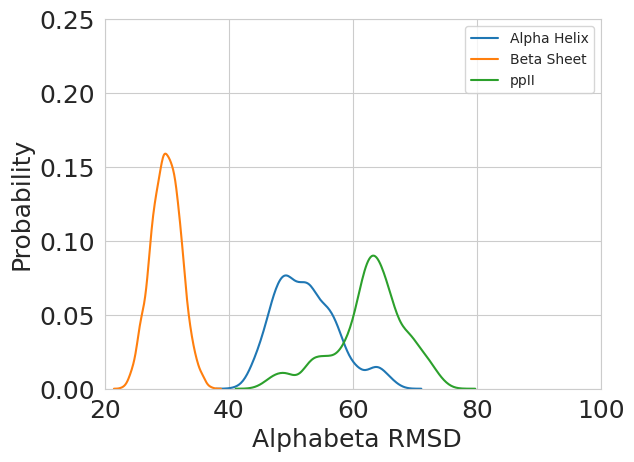

<Figure size 640x480 with 0 Axes>

In [11]:
Phi_all = phis
Psi_all = psis
alphabeta_alpharight = alphabeta_rmsd(Phi_all, Psi_all, -1.05, -0.79)
alphabeta_betasheet = alphabeta_rmsd(Phi_all, Psi_all, 2.36, -2.36)
alphabeta_ppII = alphabeta_rmsd(Phi_all, Psi_all, -1.31, 2.71)

sns.kdeplot(data=alphabeta_alpharight, label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet, label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII, label='ppII')

plt.xlabel(' Alphabeta RMSD', fontsize=18)
plt.xlim(20, 100)
plt.ylim(0, 0.25)

plt.ylabel('Probability', fontsize=18)
plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.show()
plt.savefig(outdir+'Alphabeta.histogram.png')


In [44]:
Ttotal,dt = np.array([trj.n_frames*trj.timestep,trj.timestep])/1000000

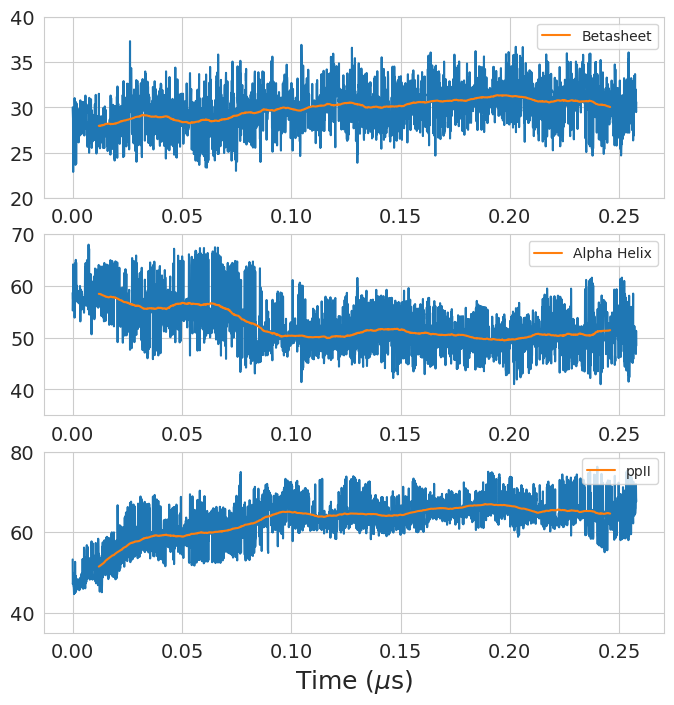

In [45]:
fig, ax = plt.subplots(3, figsize=((8, 8)))
N = 300
time = np.arange(0,Ttotal,dt)
time_window = np.convolve(time, np.ones(N)/N, mode='valid')
ax[0].plot(time,alphabeta_betasheet)
ax[0].set_ylim(20,40)
ax[0].plot(time_window,np.convolve(alphabeta_betasheet, np.ones(
    N)/N, mode='valid'), label='Betasheet')
ax[0].legend(loc='upper right')

ax[1].plot(time,alphabeta_alpharight)
ax[1].set_ylim(35,70)
ax[1].plot(time_window,np.convolve(alphabeta_alpharight, np.ones(
    N)/N, mode='valid'), label='Alpha Helix')
ax[1].legend(loc='upper right')

ax[2].plot(time,alphabeta_ppII)
ax[2].set_ylim(35,80)
ax[2].plot(time_window,np.convolve(alphabeta_ppII, np.ones(
    N)/N, mode='valid'), label='ppII')
ax[2].legend(loc='upper right')

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)

plt.xlabel(r'Time ($\mu$s)', size=18)
plt.savefig(outdir+'Alphabeta.timecourse.png')


CA Radius of Gyration: 1.350 +_ 0.032
1st Half CA Radius of Gyration: 1.293 +_ 0.032
2nd Half CA Radius of Gyration: 1.407 +_ 0.016


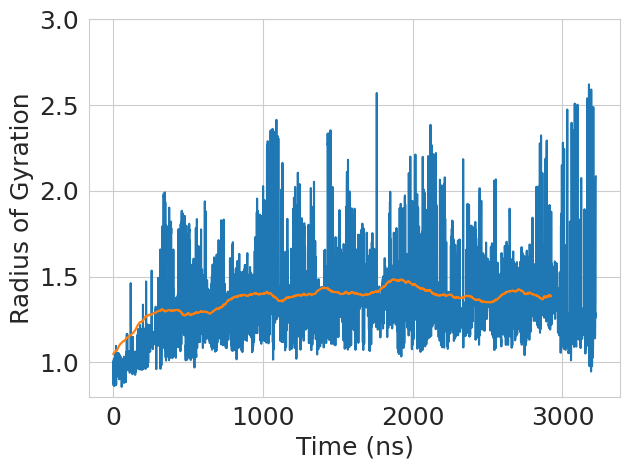

In [13]:
mass = []
for at in trj.topology.atoms:
    mass.append(at.element.mass)
mass_CA = len(mass)*[0.0]
# put the CA entries equal to 1.0
for i in trj.topology.select("name CA"):
    mass_CA[i] = 1.0
# calculate CA radius of gyration
rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
# SE_rg=(block(rg_all))**.5
plt.clf()
plt.plot(rg_CA)
plt.plot(np.convolve(rg_CA, np.ones(N)/N, mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.ylim(0.8, 3.0)
plt.tick_params(labelsize=18)
plt.tight_layout()
print("CA Radius of Gyration:%6.3lf" %
      np.average(rg_CA), "+_%6.3lf" % block(rg_CA)**.5)
print("1st Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[0:half]), "+_%6.3lf" % block(rg_CA[0:half])**.5)
print("2nd Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[half:-1]), "+_%6.3lf" % block(rg_CA[half:-1])**.5)

plt.savefig(outdir+'rg.pdf')
np.savetxt(outdir+'rg.dat', rg_CA)


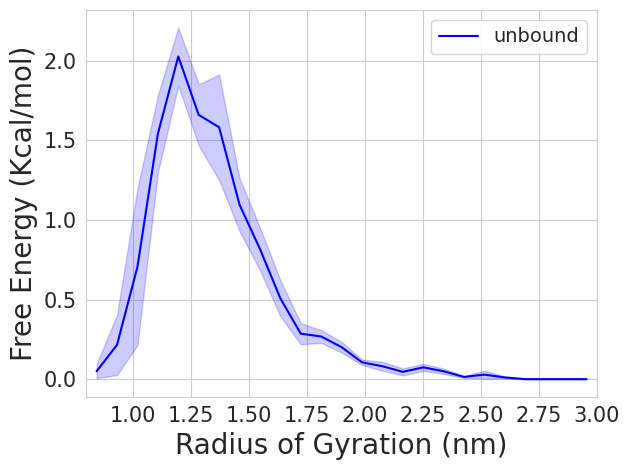

In [14]:
Rg_unbound, edges, u_err = histo_blockerror(rg_CA, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_unbound, c='blue', label='unbound')
plt.fill_between(edges, Rg_unbound-u_err, Rg_unbound +
                 u_err, color='blue', alpha=0.2)

plt.xlim(0.8, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


/home/koreyr/scripts/block.py:73: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


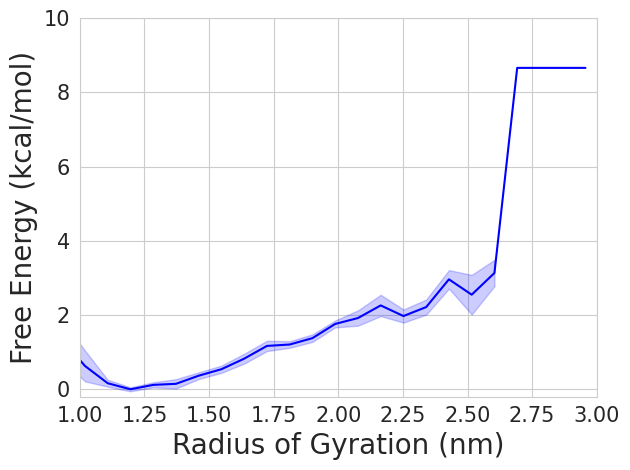

In [15]:
dG, bin_centers, ferr = free_energy_1D_blockerror(rg_CA, 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 10)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+'rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf' % outdir)
plt.show()


/home/koreyr/scripts/block.py:73: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


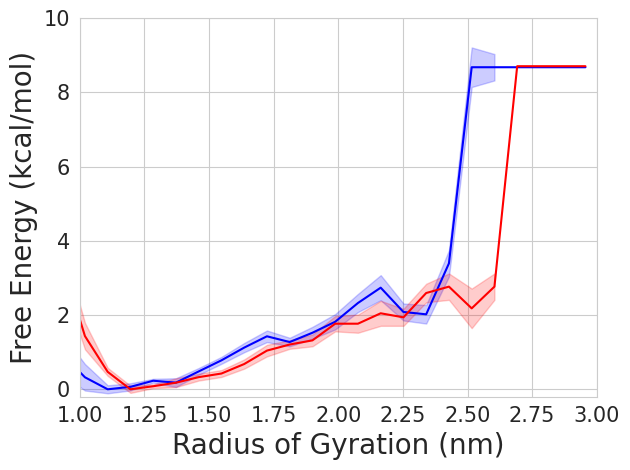

In [16]:
# [0:half],[half:-1]
dG1, bin_centers, ferr = free_energy_1D_blockerror(
    rg_CA[0:half], 300, 0.8, 3.0, 25, 5)
dG2, bin_centers, ferr = free_energy_1D_blockerror(
    rg_CA[half:-1], 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG1, color='blue')
sns.lineplot(x=bin_centers, y=dG2, color='red')

plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr, dG2+ferr, color='red', alpha=0.2)

plt.ylim(-0.2, 10)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.tight_layout()
plt.savefig('%s/Rg.dG.splithalfs.pdf' % outdir)
plt.show()


Number of residues: 44

AlphaRMSD: 1.964 +_ 0.195


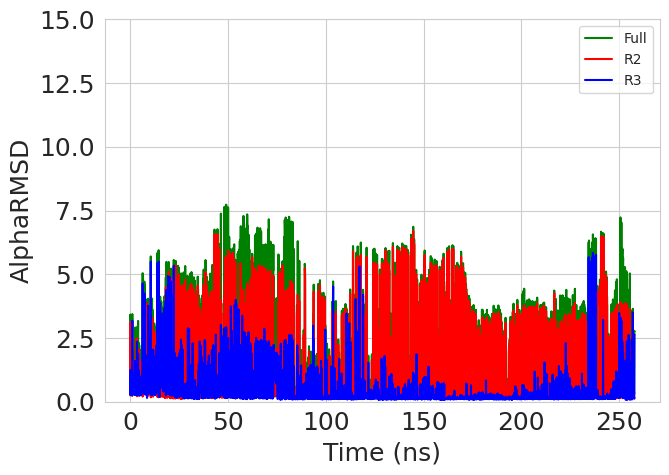

In [17]:
helix = md.load_pdb(helixpdb)
helix
top_helix = helix.topology
backbone_helix = top_helix.select("name CA")
backbone = top.select("name CA")

sel1 = top_helix.select("name CA and residue 0 to 21")
sel2 = top_helix.select("name CA and residue 22 to 43")

print("Number of residues: %d\n" % len(set(nres)))
RMS_start = 0
RMS_stop = 38
RMS = []
for i in range(RMS_start, RMS_stop):
    sel = top_helix.select("residue %s to %s and name CA" % (i, i+6))
    rmsd = md.rmsd(trj, helix, atom_indices=sel)
    RMS.append(rmsd)
RMS = np.asarray(RMS)
RMS

Sa_sum = np.zeros((trj.n_frames))
Sa = (1.0-(RMS/0.10)**8)/(1.0-(RMS/0.10)**12)
Sa_ave = np.average(Sa, axis=1)
Sa_total = np.sum(Sa, axis=0)
Sa_R2 = np.sum(Sa[0:21], axis=0)
Sa_R3 = np.sum(Sa[22:43], axis=0)
time = np.arange(0,len(Sa_total))*0.08

print("AlphaRMSD:%6.3lf" % np.average(Sa_total),
      "+_%6.3lf" % block(Sa_total)**.5)

N = 300
plt.plot(time,Sa_total, label='Full', c='g')
plt.plot(time,Sa_R2, label='R2', c='r')
plt.plot(time,Sa_R3, label='R3', c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 15)
plt.savefig(outdir+'Sa.timecourse.png')
np.savetxt(outdir+'Sa_total.dat', Sa_total)
np.savetxt(outdir+'Sa_total.R2.dat', Sa_R2)
np.savetxt(outdir+'Sa_total.R3.dat', Sa_R3)


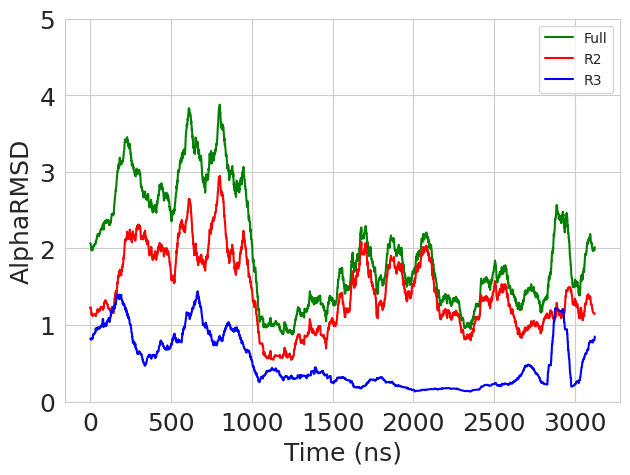

In [18]:
N = 100
plt.plot(np.convolve(Sa_total, np.ones(N)/N, mode='valid'), label='Full', c='g')
plt.plot(np.convolve(Sa_R2, np.ones(N)/N, mode='valid'), label='R2', c='r')
plt.plot(np.convolve(Sa_R3, np.ones(N)/N, mode='valid'), label='R3', c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 5)
plt.savefig(outdir+'Sa.timecourse.smooth.png')


/home/koreyr/scripts/block.py:73: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


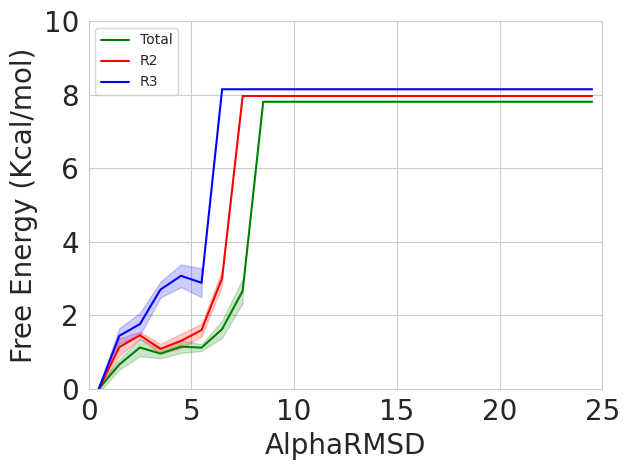

In [19]:
Sa_dg, edges, Sa_err = free_energy_1D_blockerror(Sa_total, 300, 0, 25, 25, 5)
Sa2_dg, edges, Sa2_err = free_energy_1D_blockerror(Sa_R2, 300, 0, 25, 25, 5)
Sa3_dg, edges, Sa3_err = free_energy_1D_blockerror(Sa_R3, 300, 0, 25, 25, 5)

plt.clf()
plt.plot(edges, Sa_dg, c='g', label='Total')
plt.plot(edges, Sa2_dg, c='r', label='R2')
plt.plot(edges, Sa3_dg, c='b', label='R3')
plt.fill_between(edges, Sa_dg-Sa_err, Sa_dg+Sa_err, color='g', alpha=0.2)
plt.fill_between(edges, Sa2_dg-Sa2_err, Sa2_dg+Sa2_err, color='r', alpha=0.2)
plt.fill_between(edges, Sa3_dg-Sa3_err, Sa3_dg+Sa3_err, color='b', alpha=0.2)

plt.legend()

plt.ylim(0, 10)
plt.xlim(0, 25)
plt.xlabel('AlphaRMSD', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
np.savetxt(outdir+'Sa_dg.dat', np.column_stack((edges, Sa_dg, Sa_err)))
np.savetxt(outdir+'Sa.R2dg.dat', np.column_stack((edges, Sa2_dg, Sa2_err)))
np.savetxt(outdir+'Sa.R3.dg.dat', np.column_stack((edges, Sa3_dg, Sa3_err)))
plt.savefig('%s/Sa.dG.png' % outdir)


In [20]:
rg_v_Sa = np.column_stack((rg_CA, Sa_total))
rg_cutoff = 1.3
collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]
Sa_cutoff = 6.0
helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
glob_index = np.intersect1d(collapsed, helical)
rg_v_Sa[glob_index]
globule_pop = len(glob_index)/len(rg_v_Sa)
print("Ensemble Globule Pop:", globule_pop, "Non Globule:", 1-globule_pop)
T = 300
glob_rg, glob_rg_be = get_blockerror_pyblock(rg_v_Sa[glob_index][:, 0])
rg, rg_be = get_blockerror_pyblock(rg_v_Sa[:, 0])
print("Rg:", rg, "+_", rg_be)
print("Globule Rg:", glob_rg, "+_", glob_rg_be)

T = 300
print("Free Energy Globule:", -(0.001987*T)*np.log(globule_pop))
print("Free Energy Non-Globule:", -(0.001987*T)*np.log(1-globule_pop))
print("Free Energy Difference:", -(0.001987*T)
      * np.log(globule_pop/(1-globule_pop)))


glob_binary = np.zeros(len(rg_v_Sa))
glob_binary[glob_index] = 1
glob_frac = len(glob_index)/len(glob_binary)
glob_boundfrac, glob_boundfrac_be = get_blockerror_pyblock(glob_binary)
print("Globule Fraction:", glob_boundfrac, "+_", glob_boundfrac_be)
glob_upper = glob_boundfrac+glob_boundfrac_be
non_glob = 1-glob_boundfrac
non_glob_upper = 1-(glob_boundfrac-glob_boundfrac_be)
print("Non Globule Fraction:", 1-glob_boundfrac, "+_", glob_boundfrac_be)
dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
                                      glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
print("Free Energy Difference:", dG_diff, "+_", dG_diff-dG_diff_upper)


Ensemble Globule Pop: 0.026054590570719603 Non Globule: 0.9739454094292804
Rg: 1.3502744323023965 +_ 0.033199403281316625
Globule Rg: 1.1377399527167538 +_ 0.011310844234602602
Free Energy Globule: 2.1743112937812685
Free Energy Non-Globule: 0.015737054738107437
Free Energy Difference: 2.158574239043161
Globule Fraction: 0.026054590570719603 +_ 0.009952687555797847
Non Globule Fraction: 0.9739454094292804 +_ 0.009952687555797847
Free Energy Difference: 2.158574239043161 +_ 0.19897735953047957


/tmp/ipykernel_1102972/184514981.py:24: RuntimeWarning: divide by zero encountered in log
  dG_diff=-(0.001987*T)*np.log(globule_pop/(1-globule_pop))
/tmp/ipykernel_1102972/184514981.py:25: RuntimeWarning: divide by zero encountered in log
  dG_diff_upper=-(0.001987*T)*np.log((globule_pop+glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
/tmp/ipykernel_1102972/184514981.py:29: RuntimeWarning: invalid value encountered in double_scalars
  glob_dGs_err.append(dG_diff-dG_diff_upper)


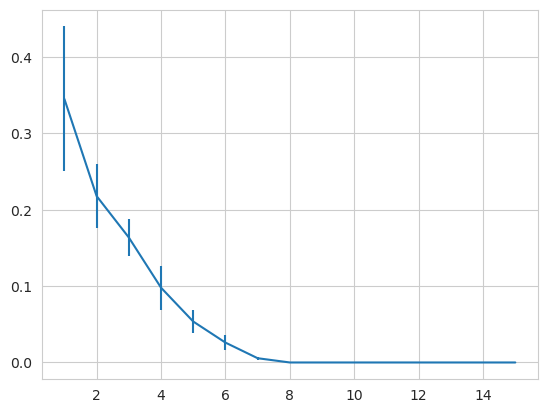

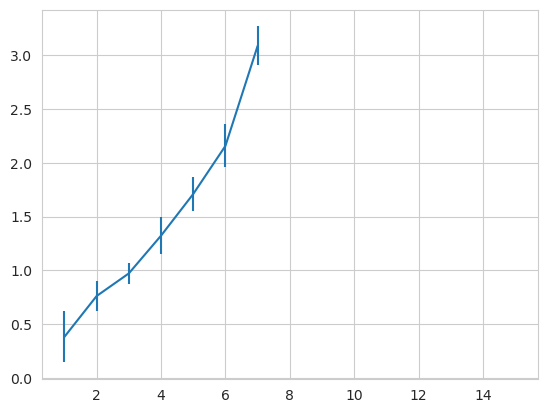

In [21]:
Sa_cut=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
glob_pops=[]
glob_errs=[]
glob_dGs=[]
glob_dGs_err=[]

rg_v_Sa=np.column_stack((rg_CA,Sa_total))
rg_cutoff=1.3
collapsed=np.where(rg_v_Sa[:,0]<rg_cutoff)[0]

for i in Sa_cut:
    Sa_cutoff=i
    helical=np.where(rg_v_Sa[:,1]>Sa_cutoff)[0]
    glob_index=np.intersect1d(collapsed,helical)
    globule_pop=len(glob_index)/len(rg_v_Sa)
    T=300
    glob_binary=np.zeros(len(rg_v_Sa))
    glob_binary[glob_index]=1
    glob_frac=len(glob_index)/len(glob_binary)
    glob_boundfrac,glob_boundfrac_be=get_blockerror_pyblock(glob_binary)
    glob_upper=glob_boundfrac+glob_boundfrac_be
    non_glob=1-glob_boundfrac
    non_glob_upper=1-(glob_boundfrac-glob_boundfrac_be)
    dG_diff=-(0.001987*T)*np.log(globule_pop/(1-globule_pop))
    dG_diff_upper=-(0.001987*T)*np.log((globule_pop+glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
    glob_pops.append(globule_pop)
    glob_errs.append(glob_boundfrac_be)
    glob_dGs.append(dG_diff)
    glob_dGs_err.append(dG_diff-dG_diff_upper)
    
plt.errorbar(Sa_cut,glob_pops,yerr=glob_errs)
plt.show()
plt.clf()
plt.errorbar(Sa_cut,glob_dGs,yerr=glob_dGs_err)
plt.show()

np.savetxt(outdir+'Pop.vs.Sacut.dat',np.column_stack((Sa_cut,glob_pops,glob_errs)))
np.savetxt(outdir+'dGglob.vs.Sacut.dat',np.column_stack((Sa_cut,glob_dGs,glob_dGs_err)))

/tmp/ipykernel_1102972/2625601018.py:26: RuntimeWarning: divide by zero encountered in log
  dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
/tmp/ipykernel_1102972/2625601018.py:27: RuntimeWarning: divide by zero encountered in log
  dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
/tmp/ipykernel_1102972/2625601018.py:33: RuntimeWarning: invalid value encountered in double_scalars
  glob_dGs_err.append(dG_diff-dG_diff_upper)


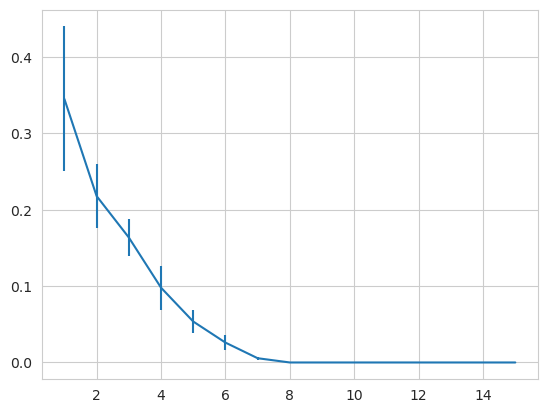

In [22]:
Sa_cut = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
glob_pops = []
glob_errs = []
glob_dGs = []
glob_dGs_err = []

rg_v_Sa = np.column_stack((rg_CA, Sa_total))
rg_cutoff = 1.3
collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]

for i in Sa_cut:
    Sa_cutoff = i
    helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
    glob_index = np.intersect1d(collapsed, helical)
    globule_pop = len(glob_index)/len(rg_v_Sa)
    T = 300
    glob_binary = np.zeros(len(rg_v_Sa))
    glob_binary[glob_index] = 1
    glob_frac = len(glob_index)/len(glob_binary)
    glob_boundfrac, glob_boundfrac_be = get_blockerror_pyblock(glob_binary)
    #print("Bound Globule Fraction:",glob_boundfrac,"+_",glob_boundfrac_be)
    glob_upper = glob_boundfrac+glob_boundfrac_be
    non_glob = 1-glob_boundfrac
    non_glob_upper = 1-(glob_boundfrac-glob_boundfrac_be)
    #print("Non Globule Fraction:",1-glob_boundfrac,"+_",glob_boundfrac_be)
    dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
    dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
                                          glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
    #print("Free Energy Difference:",dG_diff,"+_",dG_diff-dG_diff_upper)
    glob_pops.append(globule_pop)
    glob_errs.append(glob_boundfrac_be)
    glob_dGs.append(dG_diff)
    glob_dGs_err.append(dG_diff-dG_diff_upper)

plt.errorbar(Sa_cut, glob_pops, yerr=glob_errs)
plt.show()
np.savetxt(outdir+'Pop.vs.Sacut.dat',
           np.column_stack((Sa_cut, glob_pops, glob_errs)))


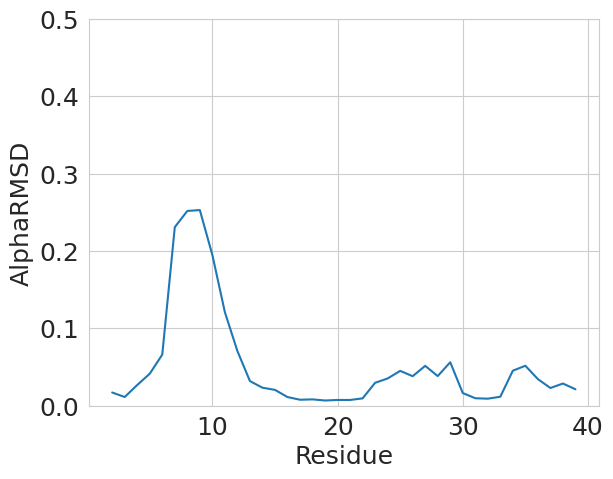

In [23]:
plt.plot(prot_res_renum[0:38], Sa_ave)
plt.xlabel('Residue', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 0.5)
plt.savefig('%s/Sa.ave.png' % outdir)


In [24]:
contact_maps = []
contact_distances = []
for i in range(0, 44):
    contact_map = []
    contact_distance = []
    for j in range(0, 44):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [25]:
for i in top.residues:
    print(f"{i} ",end='')

NGLY1 MET2 ALA3 SER4 ASN5 ASP6 TYR7 THR8 GLN9 GLN10 ALA11 THR12 GLN13 SER14 TYR15 GLY16 ALA17 TYR18 PRO19 THR20 GLN21 PRO22 GLY23 GLN24 GLY25 TYR26 SER27 GLN28 GLN29 SER30 SER31 GLN32 PRO33 TYR34 GLY35 GLN36 GLN37 SER38 TYR39 SER40 GLY41 TYR42 SER43 CGLN44 

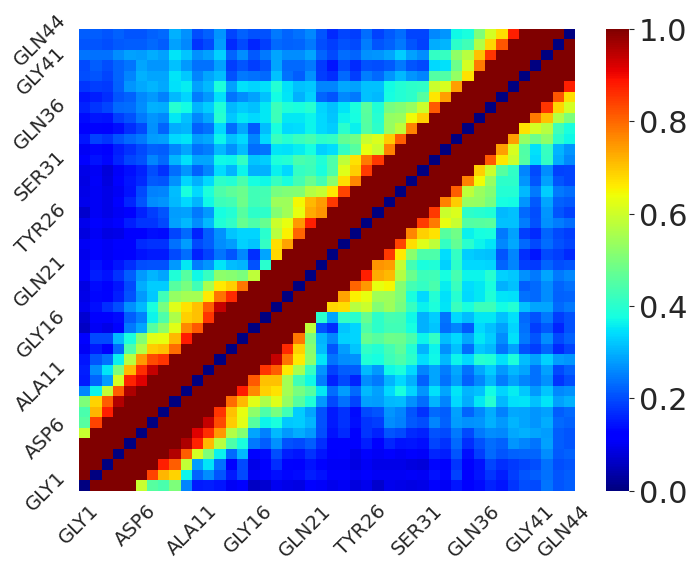

In [26]:
contact_map = final_map
sequence = ['GLY1', '', '', '', '', 'ASP6', '', '', '', '', 'ALA11', '', '', '', '', 'GLY16', '', '', '', '', \
            'GLN21', '', '','','', 'TYR26','', '', '', '', 'SER31', '', '', '', '', 'GLN36', '', '', '', '', \
            'GLY41', '', '', 'GLN44']

# Make distance map
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap='jet', ax=ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(range(0, 44), sequence, rotation=45, size=14)
plt.yticks(range(0, 44), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()


np.savetxt(outdir+'contactmap.dat', final_map)
plt.savefig(outdir+'contact_map.png')
plt.savefig(outdir+'contact_map.pdf')
plt.show()


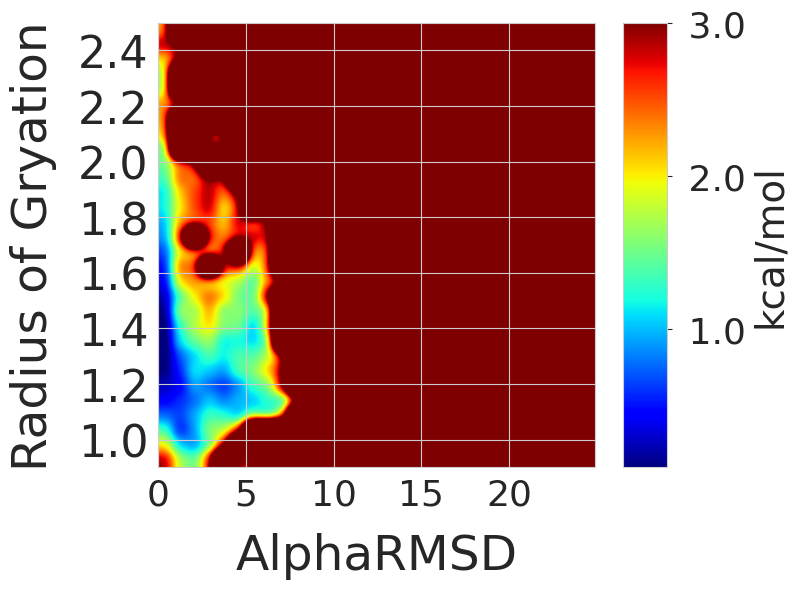

In [27]:
a, xedges, yedges = np.histogram2d(
    rg_CA, Sa_total, 30, [[0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
cb.set_label('kcal/mol',rotation=90, fontsize=28)
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("AlphaRMSD", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'hd.Rg_v_Sa.dG.dat', a)
plt.savefig(outdir+'hd.Rg_v_Sa.dG.pdf')


<Figure size 640x480 with 0 Axes>

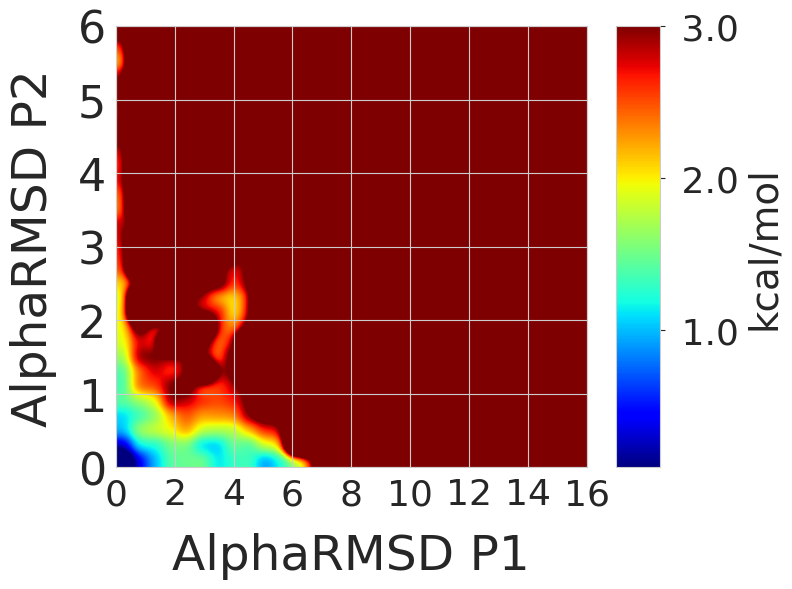

In [28]:
dG, xedges, yedges = free_energy(Sa_R3, Sa_R2, 300, 0, 6.0, 0, 16.0)

# a,xedges,yedges=np.histogram2d(Sa_total_H2,Sa_total_H1,35,[[0,3.5],[0,12]],normed=True,weights=None)
# a=np.log(np.flipud(a)+.000001)
# T=300
# a=-(0.001987*T)*a

plt.clf()
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
cb.set_label('kcal/mol',rotation=90, fontsize=28)
plt.ylabel("AlphaRMSD P2", size=35, labelpad=15)
plt.xlabel("AlphaRMSD P1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')

plt.tight_layout()
np.savetxt(outdir+'SaP1_v_SaP2.dg.dat', dG)
plt.savefig(outdir+'P1_v_P2.pdf')


In [37]:
def cmaps(traj,res0, res1):
    contact_maps = []
    contact_distances = []
    for i in range(res0, res1):
        contact_map = []
        contact_distance = []
        for j in range(res0, res1):
            if i == j:
                contacts = 0
            else:
                dist = md.compute_contacts(traj, [[i, j]])
                array = np.asarray(dist[0]).astype(float)
                distance = np.average(array)
                contact_distance.append(distance)
                contact = np.where(array < 1.2, 1, 0)
                contacts = np.average(contact)
            contact_map.append(contacts)
        contact_maps.append(contact_map)
        contact_distances.append(contact_distance)
    final_map = np.asarray(contact_maps).astype(float)
    #final_distance = np.asarray(contact_distances).astype(float)
    return final_map
#, final_distance

Demux trajectory analysis

In [30]:
demux='/home/koreyr/data/FUS/hdFUS_2x/REST/demux/'

In [46]:
replica0,nrep=1,20
sequence = ['GLY1', '', '', '', '', 'ASP6', '', '', '', '', 'ALA11', '', '', '', '', 'GLY16', '', '', '', '', \
            'GLN21', '', '','','', 'TYR26','', '', '', '', 'SER31', '', '', '', '', 'GLN36', '', '', '', '', \
            'GLY41', '', '', 'GLN44']

for i in range(replica0,replica0+nrep):
    rep = demux+str(i)+'.mol.xtc'
    traj_temp = md.load(rep, top=pdb, stride=1)
    contact_map = cmaps(traj_temp,0,44)
    np.savetxt('./Analysis/contact_map.'+str(i)+'.dat',contact_map)
    Sa = calc_SA(traj_temp, helix, 0, 44)
    Sa_total = np.sum(Sa, axis=0)
    np.savetxt(f"./Analysis/Sa_total.{i}.dat", Sa_total)
    rg_Ca = calc_Rg(traj_temp)
    np.savetxt(f"./Analysis/rg_ca.{i}.dat", rg_Ca)

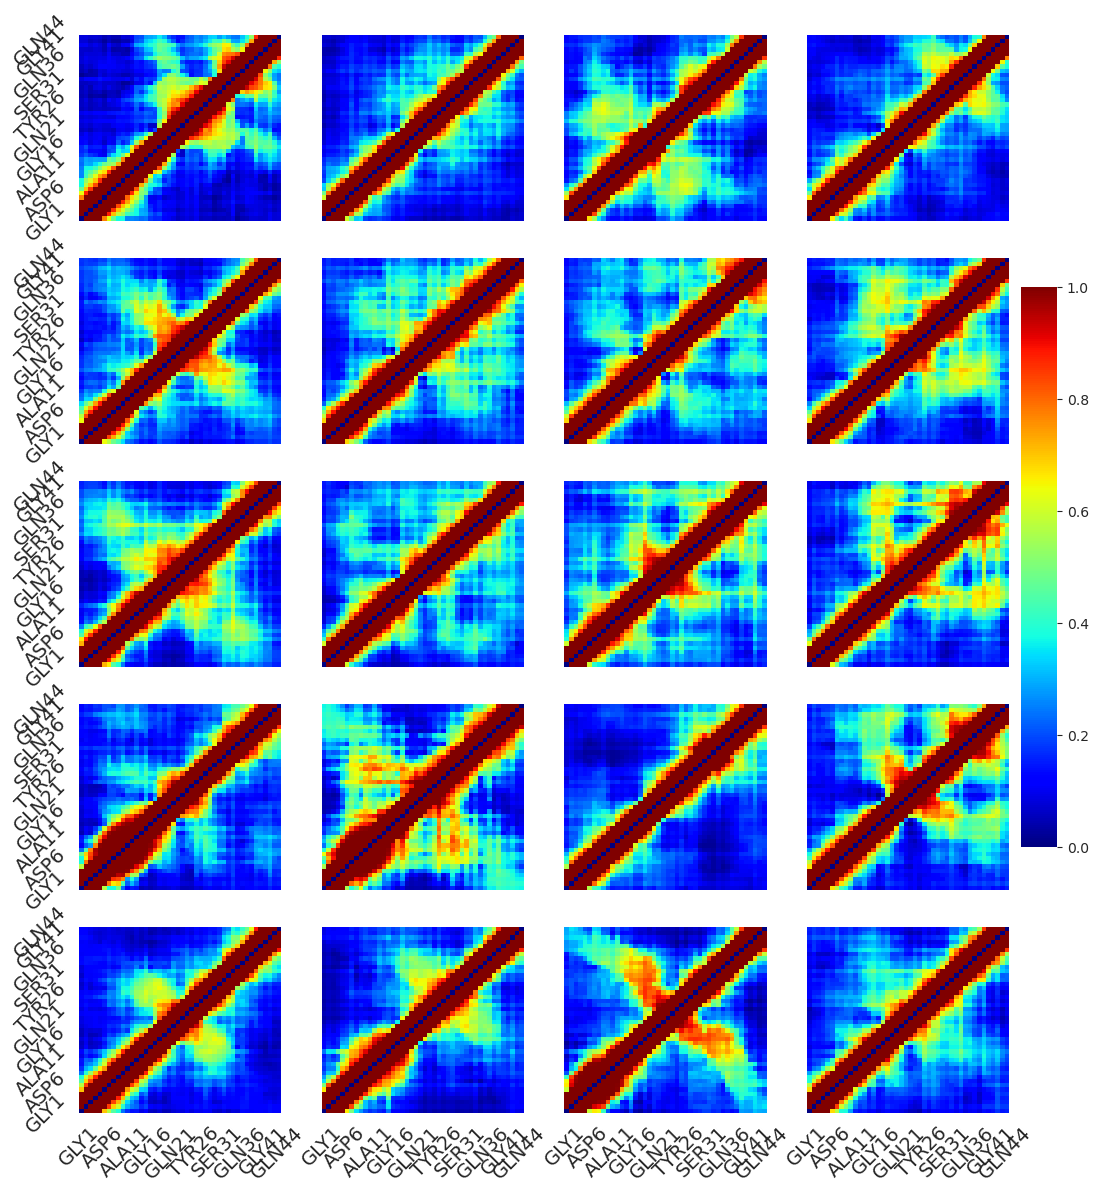

In [47]:
ncol = 4
nrow = int(nrep/ncol)
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(12, 14))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(replica0,replica0+nrep):
    contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    p, q = np.unravel_index(i-1,(nrow,ncol))
    cb = i==1
    subplot_snsheat(contact_map, ax=ax[p,q], cbar=cb, cbar_ax=cbar_ax)
    ax[p,q].set_xticks(range(0, 44), sequence, rotation=45, size=14)
    ax[p,q].set_yticks(range(0, 44), sequence, rotation=45, size=14)
    ax[p,q].invert_yaxis()


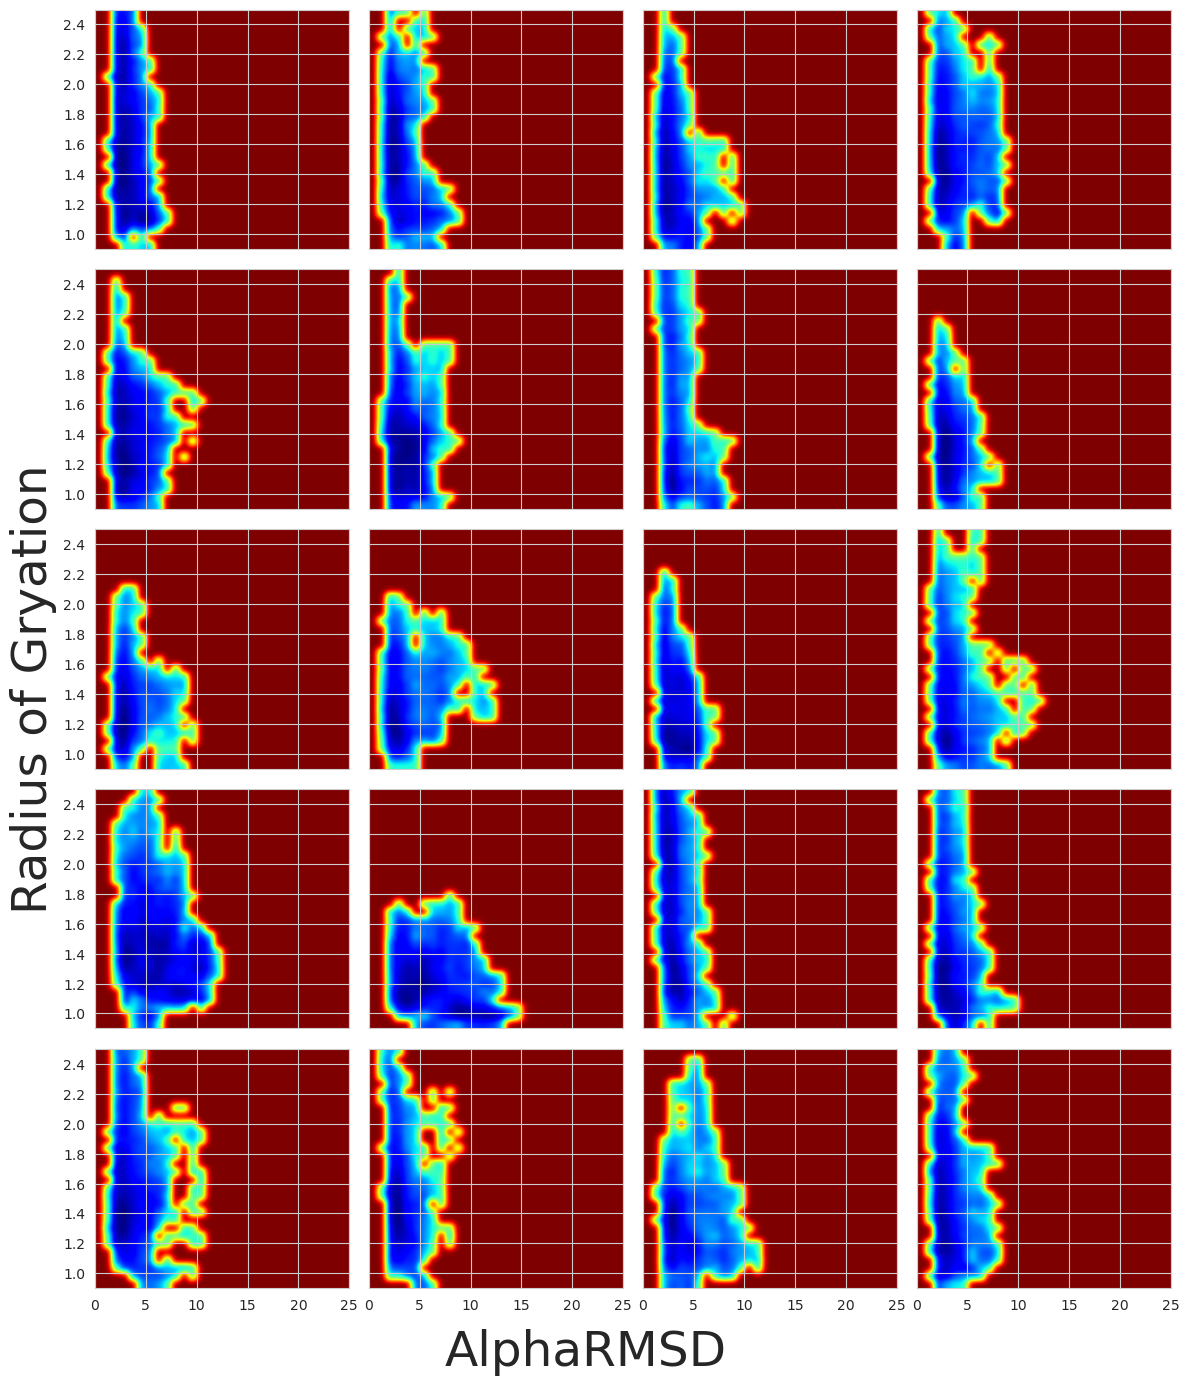

In [48]:
replica0,nrep=1,20
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(12, 14))
T = 300

for i in range(replica0,replica0+nrep):
    rg_Ca = np.loadtxt(f"./Analysis/rg_ca.{i}.dat")
    Sa_total = np.loadtxt(f"./Analysis/Sa_total.{i}.dat")
    a, xedges, yedges = np.histogram2d(
        rg_Ca, Sa_total, 30, [[0.9, 2.5], [0, 25.0]], normed=True, weights=None)
    
    a = np.log(np.flipud(a)+.000001)
    a = -(0.001987*T)*a
    p, q = np.unravel_index(i-1,(nrow,ncol))

    subplot_imshow(a, xedges, yedges, ax[p,q])
    
    cbar_ticks = [0, 1, 2, 3, 4, 5]
    #ax[p,q].set_xlim(0, 24.9)
    #cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
    #                  aspect=10)  # grab the Colorbar instance
    imaxes = plt.gca()
    #cb.set_label('kcal/mol',rotation=90, fontsize=28)
    #plt.xticks(fontsize=35)
    #plt.yticks(fontsize=35)
    #plt.xticks(size='26')
    #plt.yticks(size='32')
    #plt.axes(cb.ax)
    #plt.clim(vmin=0.1, vmax=3.0)
    #plt.yticks(size='26')
fig.supylabel("Radius of Gryation", size=35)
fig.supxlabel("AlphaRMSD", size=35)


plt.tight_layout()


In [49]:
helix_prob = []
for i in range(replica0,replica0+nrep):
    rep = demux+str(i)+'.mol.xtc'
    traj_temp = md.load(rep, top=pdb, stride=1)
    helix_prob.append(np.where(md.compute_dssp(traj_temp) == "H", 1,0).mean(0))

In [50]:
lstyle_dic = {i:'--' if i < 10 else '-.' for i in range(20) }

Text(0.5, 0, 'Residue')

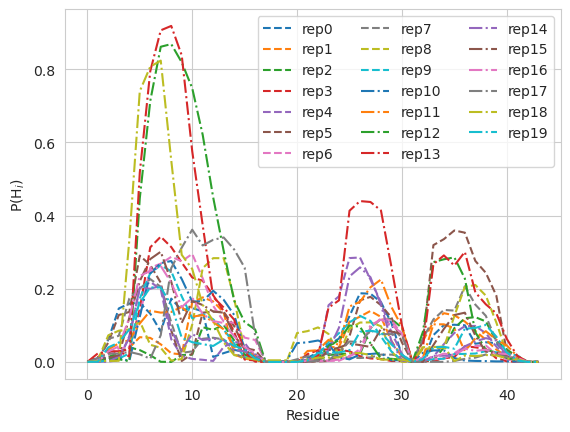

In [51]:
count=0
for i in helix_prob:
    plt.plot(np.arange(0,44), i, label='rep'+str(count), linestyle=lstyle_dic[count])
    count+=1
plt.legend(ncol=3)
plt.ylabel('P(H$_i$)')
plt.xlabel('Residue')